# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [ ]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip


## Imports

In [74]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

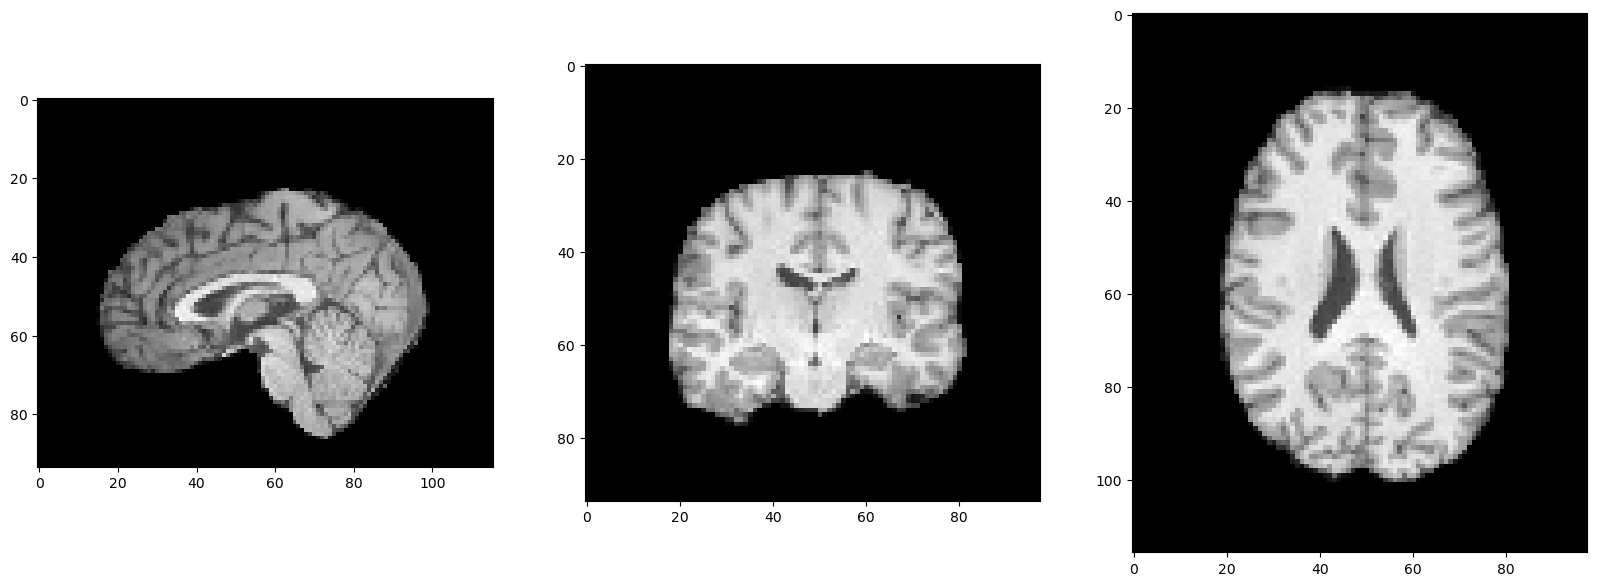

In [2]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [3]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:03<00:00, 197.72it/s]


In [4]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|██████████| 652/652 [00:00<00:00, 133249.83it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

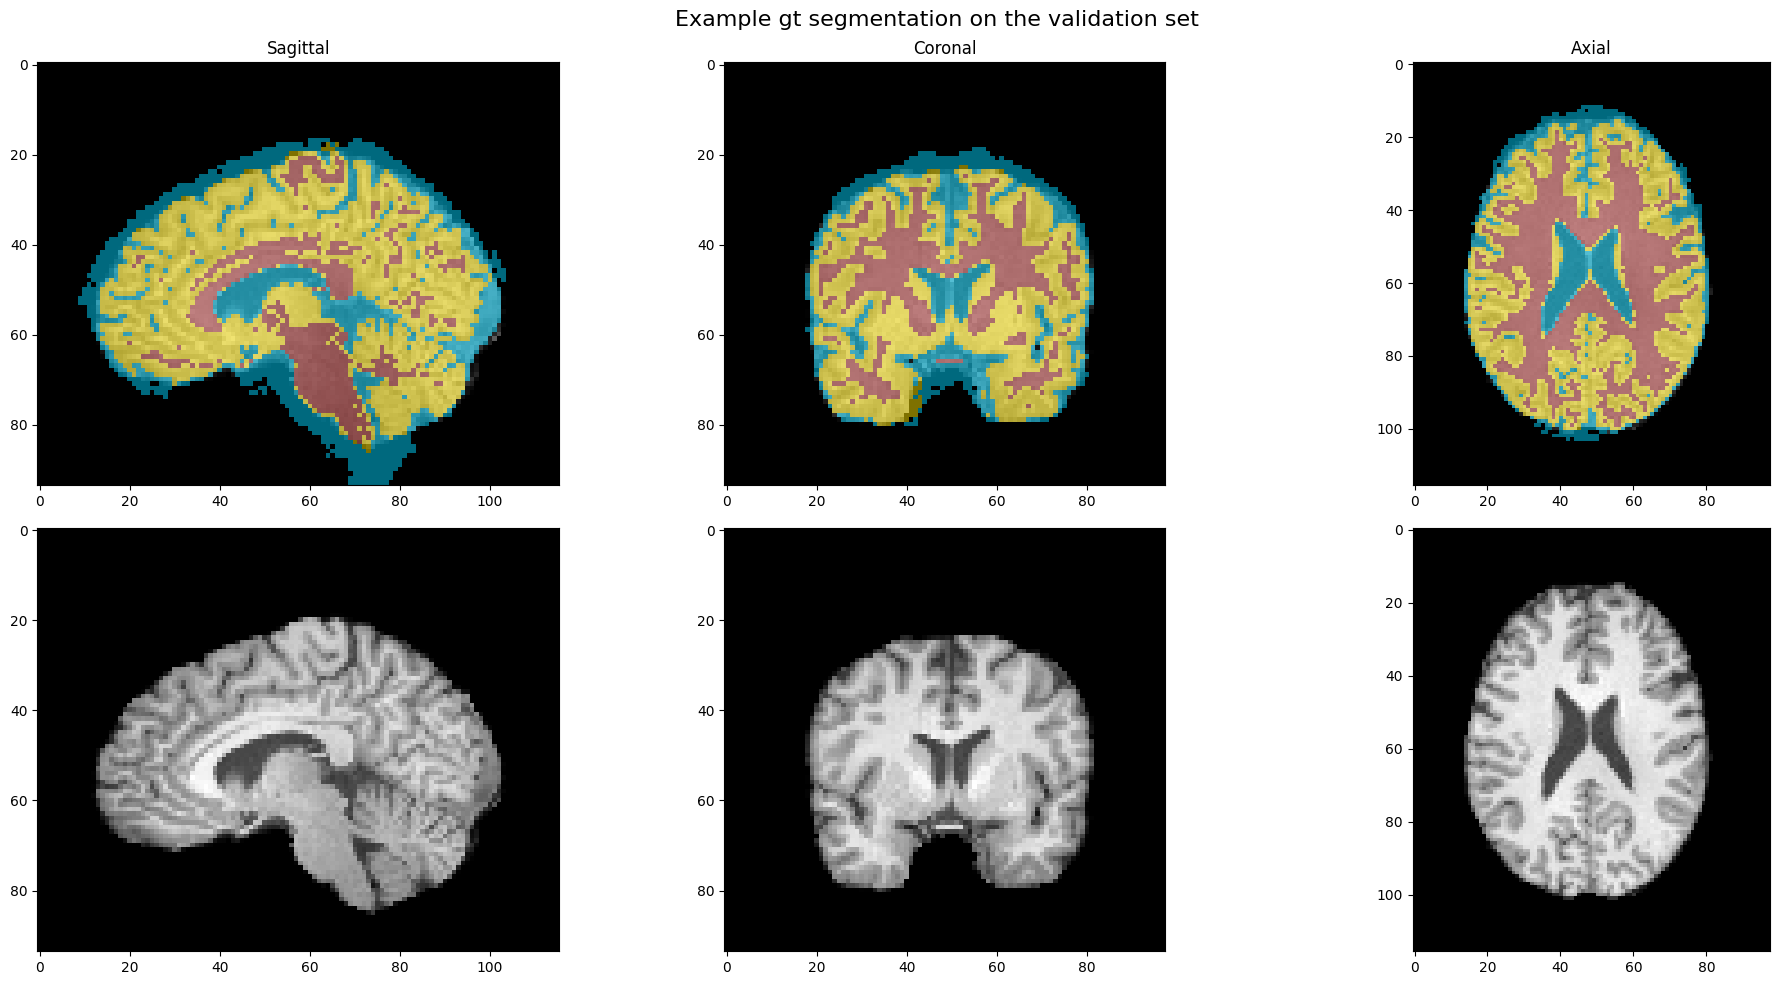

In [5]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [8]:
np.unique(np.array(segmentations_test)[15])

array([0., 1., 2., 3.], dtype=float32)

In [47]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes.
# --------------------------- ADD YOUR CODE HERE ------------------------------

def dice_coefficient_precision_recall(predictions, gt): 
  predictions = np.array(predictions)
  gt = np.array(gt)

  unique_classes = np.unique(gt)
  num_classes = len(unique_classes)
  num_patients = predictions.shape[0]

  dice = np.zeros((num_classes, num_patients))
  precision = np.zeros((num_classes, num_patients))
  recall = np.zeros((num_classes, num_patients))

  for patient_idx in range(num_patients):
      for i, cls in enumerate(unique_classes):
        pred = predictions[patient_idx, :, :, :]
        ground_truth = gt[patient_idx, :, :, :]

        true_positive = np.sum(np.logical_and(pred == cls, ground_truth == cls))
        false_positive = np.sum(np.logical_and(pred == cls, ground_truth != cls))
        false_negative = np.sum(np.logical_and(pred != cls, ground_truth == cls))

        # Calculate Dice, precision, and recall for the current class and patient
        dice[i, patient_idx] = (2.0 * true_positive) / (2.0 * true_positive + false_positive + false_negative + 1e-5)
        precision[i, patient_idx] = true_positive / (true_positive + false_positive + 1e-5)
        recall[i, patient_idx] = true_positive / (true_positive + false_negative + 1e-5)

  return dice, precision, recall
def Dice(predictions, gt):

  dice, _, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = dice.mean(axis=0), dice.std(axis=0)
  return mean, std

def precision(predictions, gt):

  _, precision, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = precision.mean(axis=0) , precision.std(axis=0)
  return mean, std

def recall(predictions, gt):

  _, _, recall = dice_coefficient_precision_recall(predictions, gt)
  mean, std = recall.mean(axis=0), recall.std(axis=0)
  return mean, std

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [48]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1

    # TODO: implement
    dice_scores = Dice(predictions, segmentations_test)[0]

    # Find the index of the best and worst Dice scores
    best_ids = np.argmax(dice_scores)
    worst_ids = np.argmin(dice_scores)
    # print(dice_scores.shape)
    best_performance, worst_performance = dice_scores[best_ids], dice_scores[worst_ids]
    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')

# ----------------------------------- END -------------------------------------

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

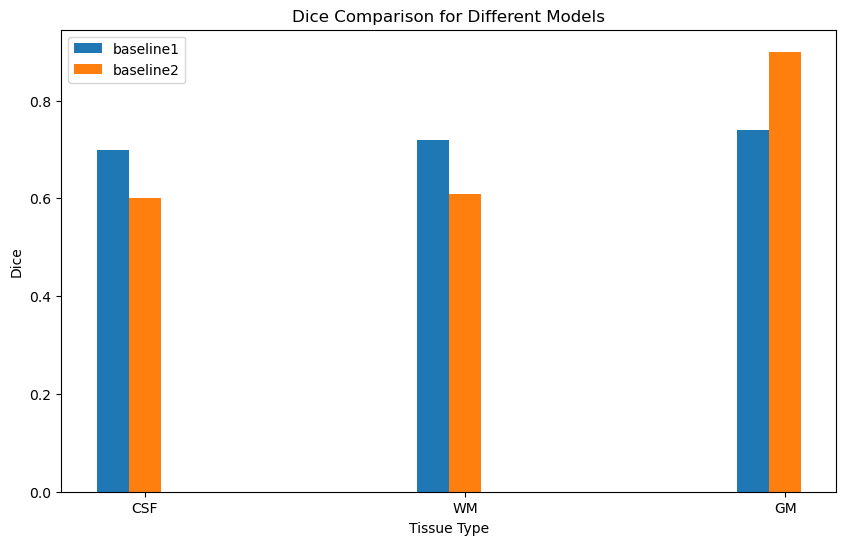

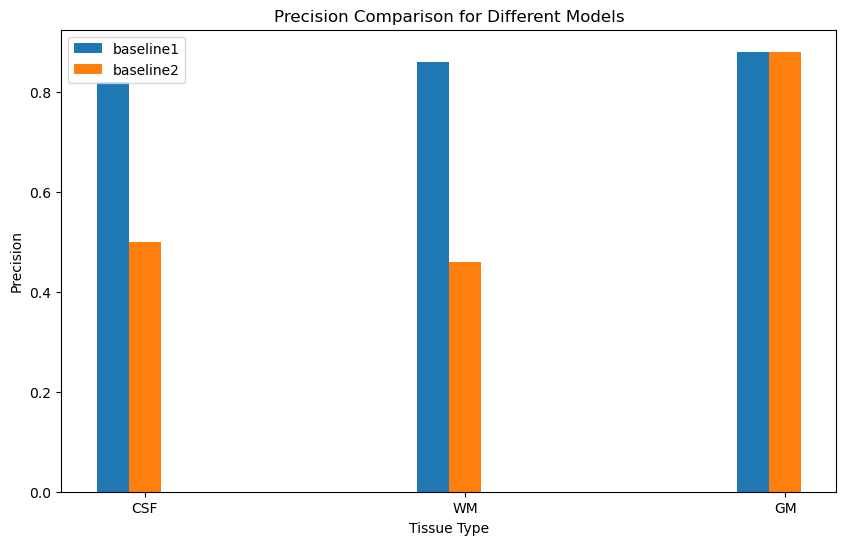

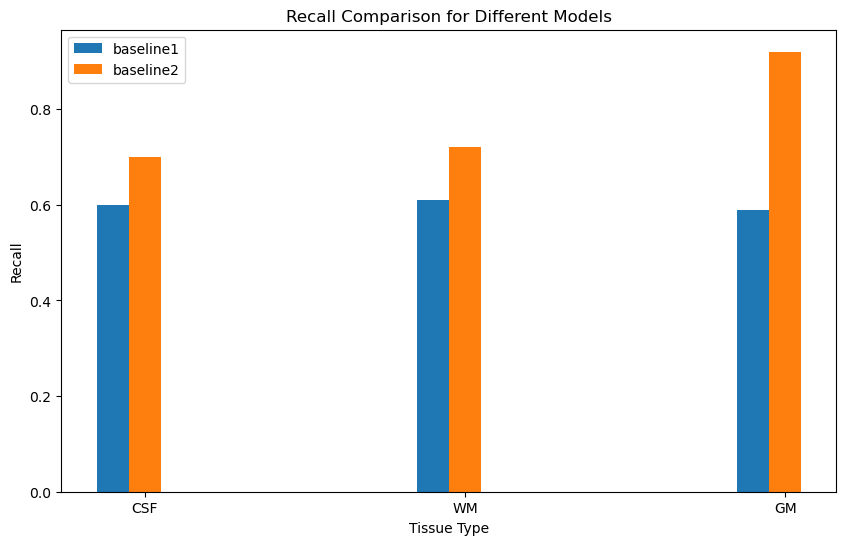

In [49]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

def get_results_dictionary(predictions):
    results_dict = {}
    tissues = ['CSF', 'WM', 'GM']
    for i, tissue in enumerate(tissues): 

        dict_ = {'dice': '-1', 'precision': '-1', 'recall': '-1'}

        dict_['dice'] = str(Dice(predictions[i], segmentations_test)[0].mean())
        dict_['precision'] = str(precision(predictions[i], segmentations_test)[0].mean())
        dict_['recall'] = str(recall(predictions[i], segmentations_test)[0].mean())
        
        results_dict[tissues[i]] = dict_

    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    
    tissues = list(next(iter(results_dict.values())).keys())
    metrics = ['dice', 'precision', 'recall']
    models = list(results_dict.keys())

    bar_width = 0.1
    index = np.arange(len(tissues))

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for i, model in enumerate(models):
            values = [float(results_dict[model][tissue][metric]) for tissue in tissues]
            plt.bar(index + i * bar_width, values, bar_width, label=model)

        plt.xlabel('Tissue Type')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Comparison for Different Models')
        plt.xticks(index + (len(models) / 2) * bar_width, tissues)
        plt.legend()

        plt.show()
# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}
plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

In [ ]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [ ]:
# Unsupervised method 1
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_1 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [ ]:
# Unsupervised method 2
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
sns_plot_2 = None
# ----------------------------------- END -------------------------------------

In [ ]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [5]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
from __future__ import annotations

import monai
from monai.apps.utils import download_and_extract
from monai.data import DataLoader, CacheDataset, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

from monai.networks.utils import one_hot
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference

import torch
from monai.networks.nets import UNet

root_dir = './model'


In [19]:
from skimage.transform import resize

def load_data_from_list_3d(image_files, segmentation_files):
  # index =
  # [i,:,:,0] sagital
  # [:, i, : , 0] coronal
  # [:, : , i, 0] axial
  images = []
  labels = []
  new_size = (96, 112, 96)
  for j in range(int(len(segmentation_files))):
  # for j in range(30):
    slice_images = nib.load(image_files[j]).get_fdata()
    # Assuming new_size is your desired size tuple (e.g., (height, width, depth))
    resized_img = resize(slice_images, new_size, anti_aliasing=True)
    slice_labels = segmentation_files[j]
    # Assuming new_size is your desired size tuple (e.g., (height, width, depth))
    resized_img = resize(slice_labels, new_size, anti_aliasing=True)
    resized_labels = resize(slice_labels, new_size, anti_aliasing=True)    
    slice_images = np.expand_dims(resized_img, axis=0)
    slice_labels = np.expand_dims(resized_labels, axis=0)
    images.append(slice_images)
    labels.append(slice_labels)
  return images, labels

In [20]:
train_images, train_labels = load_data_from_list_3d(train_files, segmentations_train)
train_img = [{"img": img, "seg": seg} for img, seg in (zip(train_images, train_labels))]
train_ds = CacheDataset(data=train_img,transform=None)
train_loader_3d = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

val_images, val_labels = load_data_from_list_3d(val_files, segmentations_val)
val_img = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
val_ds = CacheDataset(data=val_img, transform=None)
val_loader_3d = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

test_images, test_labels = load_data_from_list_3d(test_files, segmentations_test)
test_img = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_labels)]
test_ds = CacheDataset(data=test_img, transform=None)
test_loader_3d = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset: 100%|██████████| 65/65 [00:00<00:00, 792528.37it/s]


In [23]:
def train_quicknat3D(model, train_loader, val_loader, view):
    print(f"training of {view} UNet")
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-3)
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    max_epochs = 20
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    best_model = None
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["img"].to(device),
                batch_data["seg"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["img"].to(device),
                        val_data["seg"].to(device),
                    )
                    roi_size = (96, 112, 96)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    labels_oneHot = one_hot(val_labels, 4)
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs > 0.5 , y=labels_oneHot)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_model = model.state_dict()
                    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    
    return best_model


In [24]:
epochs = 5
device = 'cpu'
model3d = UNet(spatial_dims = 3,
             in_channels = 1,
             out_channels=4,
             channels=(4, 8, 16, 32, 64),
             strides=(2, 2, 2, 2),
             num_res_units=2) 
model_test = train_quicknat3D(model3d, train_loader_3d, val_loader_3d, "3d")


training of 3d UNet
----------
epoch 1/20
1/32, train_loss: 0.8267
2/32, train_loss: 0.8084
3/32, train_loss: 0.7929
4/32, train_loss: 0.7858
5/32, train_loss: 0.7726
6/32, train_loss: 0.7577
7/32, train_loss: 0.7544
8/32, train_loss: 0.7418
9/32, train_loss: 0.7373
10/32, train_loss: 0.7324
11/32, train_loss: 0.7275
12/32, train_loss: 0.7270
13/32, train_loss: 0.7181
14/32, train_loss: 0.7128
15/32, train_loss: 0.7106
16/32, train_loss: 0.6990
17/32, train_loss: 0.6915
18/32, train_loss: 0.6886
19/32, train_loss: 0.6798
20/32, train_loss: 0.6776
21/32, train_loss: 0.6649
22/32, train_loss: 0.6696
23/32, train_loss: 0.6579
24/32, train_loss: 0.6517
25/32, train_loss: 0.6506
26/32, train_loss: 0.6458
27/32, train_loss: 0.6383
28/32, train_loss: 0.6264
29/32, train_loss: 0.6186
30/32, train_loss: 0.6186
31/32, train_loss: 0.6118
32/32, train_loss: 0.6107
33/32, train_loss: 0.6034
epoch 1 average loss: 0.6973
----------
epoch 2/20
1/32, train_loss: 0.6114
2/32, train_loss: 0.6066
3/32, tr

In [ ]:
model_path =  os.path.join('./model', "best_metric_model.pth")
torch.save(model3d.state_dict(), model_path)

In [70]:
def get_prediction(model, test_loader, model_path):
    combined_tensors = []
    model.load_state_dict(torch.load(model_path))
    model.eval()
    new_size = (98, 116, 94)
    for i, batch_data in enumerate(test_loader):
        # Get predictions for image
        pred = model(batch_data["img"]).argmax(dim=1)
        current_size = pred.shape[1:]

        # Use interpolate to resize the tensor to the target size
        resized_tensor = F.interpolate(pred.unsqueeze(0).float(), size=new_size, mode='nearest').long().squeeze(0)

        # Append the resized tensor to the list
        combined_tensors.append(resized_tensor.squeeze(0))

    return combined_tensors

In [71]:
# Define and train a neural network (U-Net) for segmentation
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
pred_seg_3 = get_prediction(model3d, test_loader_3d, model_path)
# ----------------------------------- END -------------------------------------

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None
# ----------------------------------- END -------------------------------------

torch.Size([98, 116, 94])


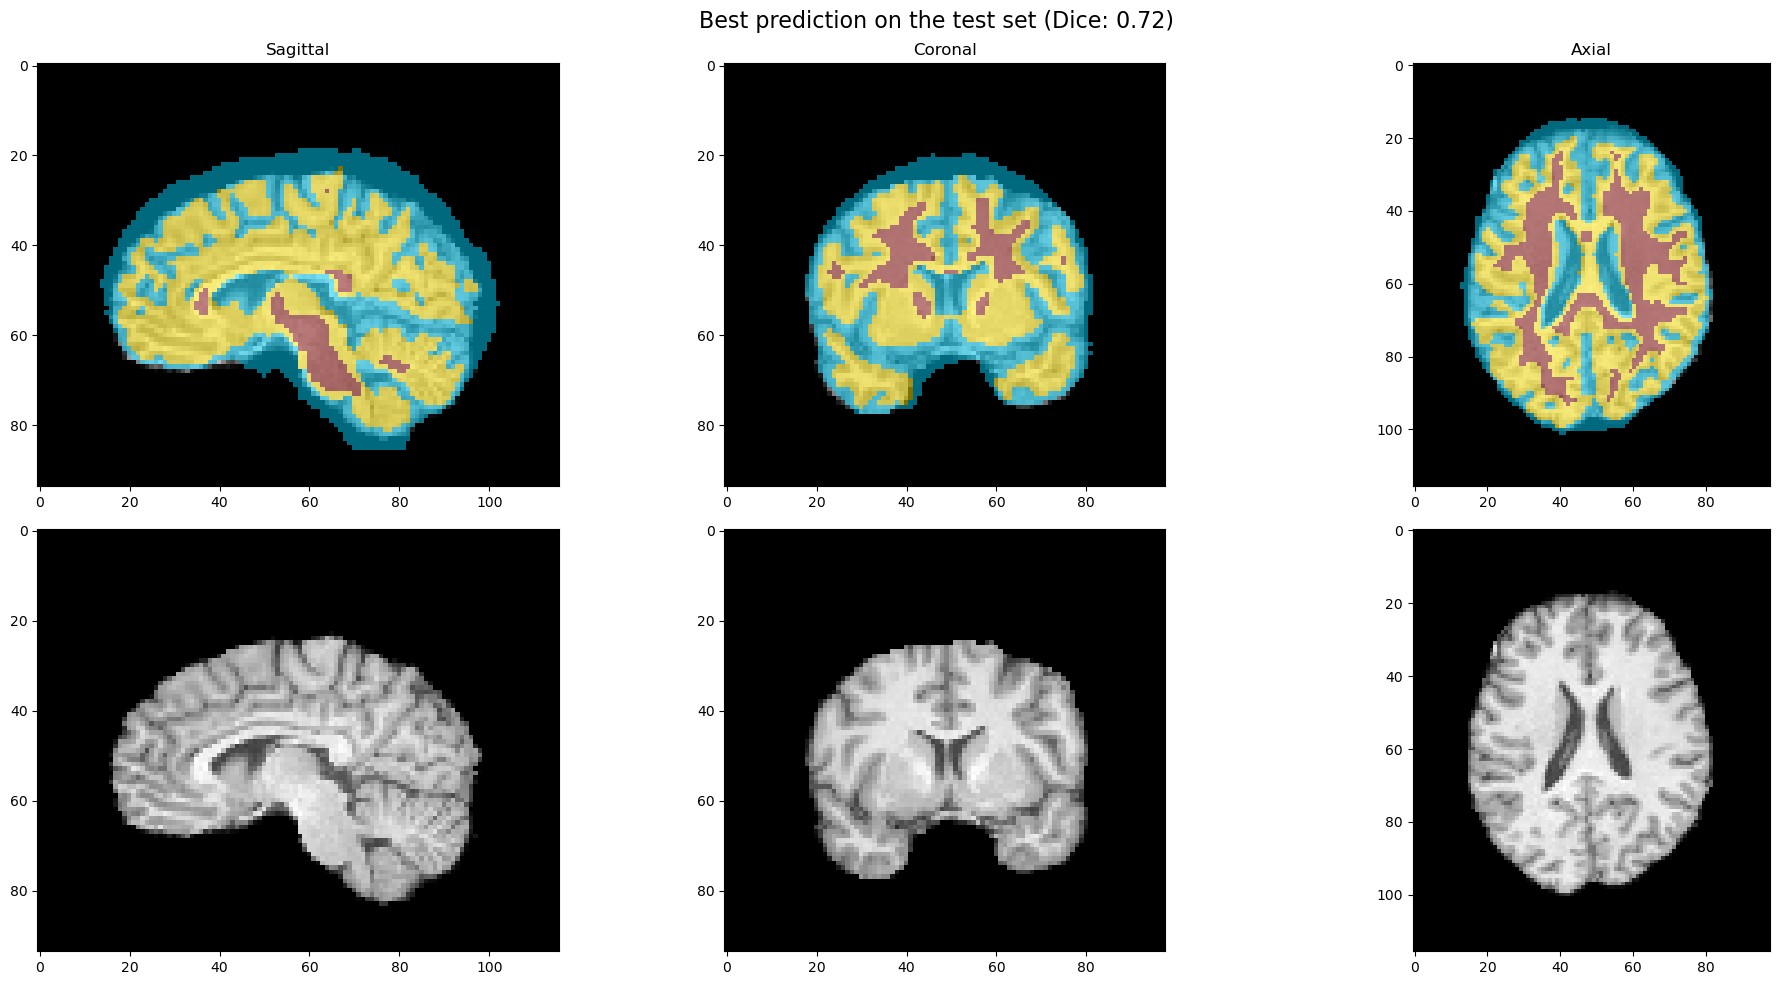

torch.Size([98, 116, 94])


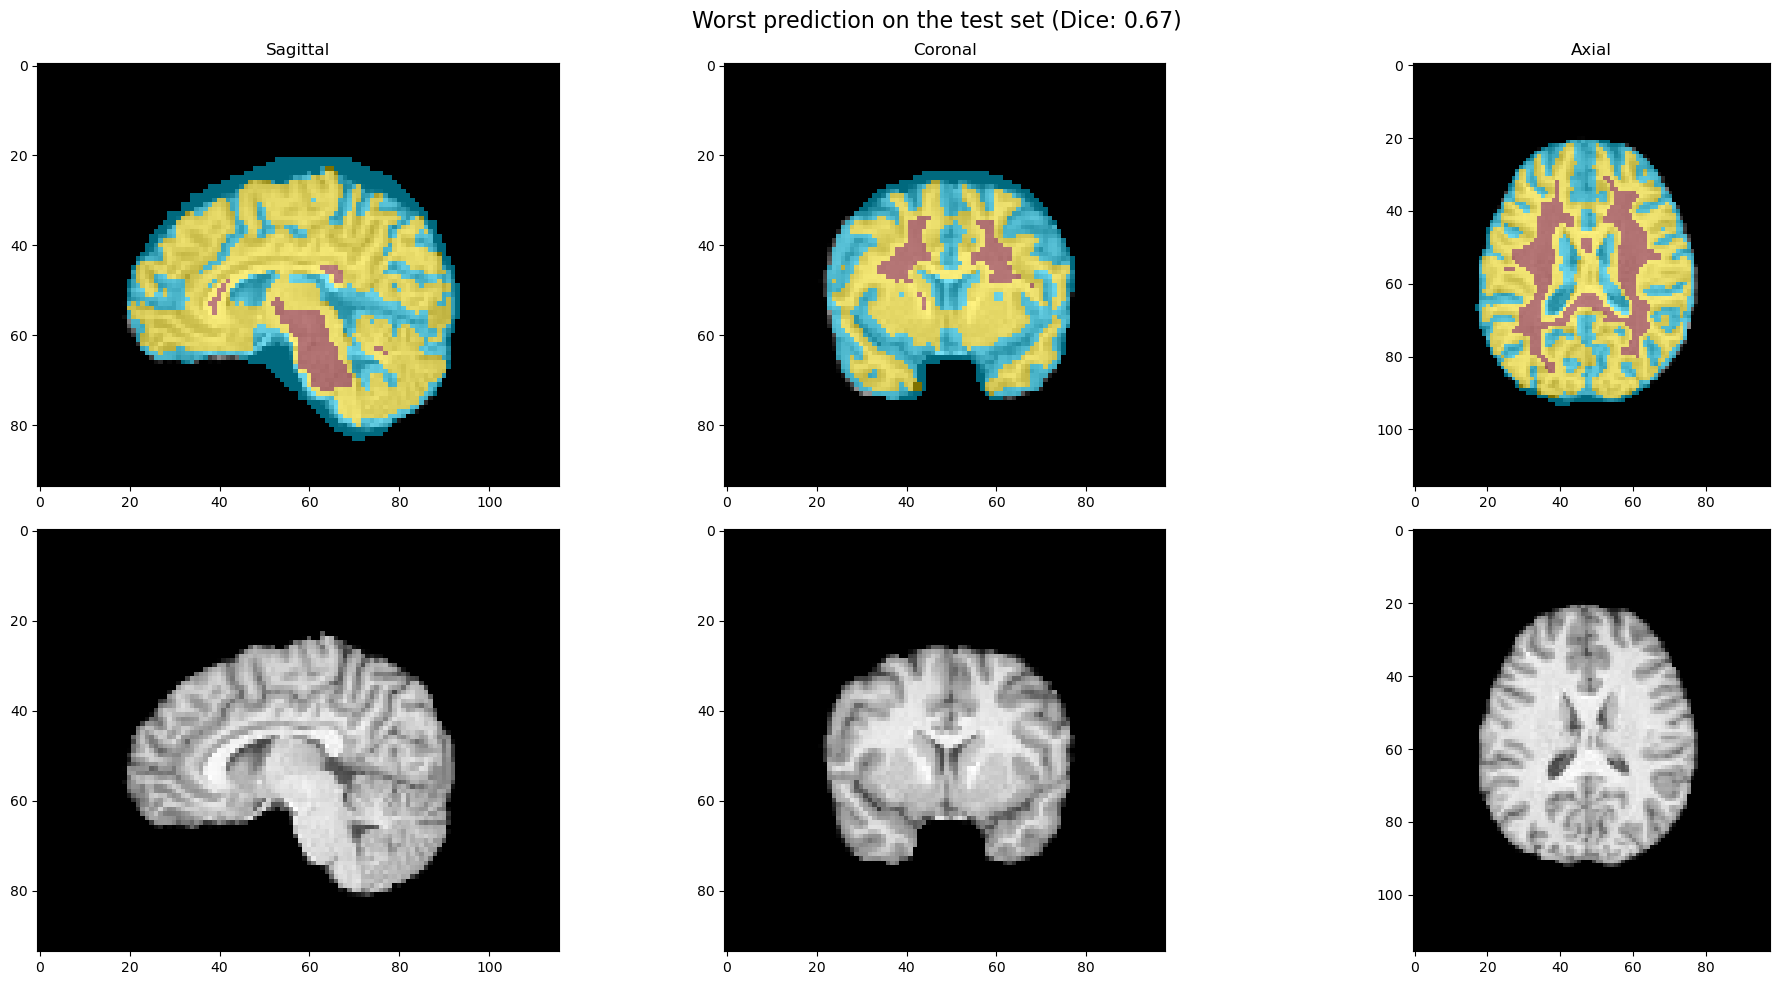

In [78]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

In [ ]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1),
    'unsupervised2': get_results_dictionary(pred_seg_2),
    'u-net': get_results_dictionary(pred_seg_3),
}
plot_results_summary(results_dictionary)